<center><h1 style="font-size: 4em; color: Green;">Emotion Detection</h1></center>

# Import Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from notebook.services.config import ConfigManager

cm = ConfigManager()
cm.update('notebook', {
    "NotebookApp": {
        "iopub_msg_rate_limit": 10000,
        "rate_limit_window": 10.0
    }
})

{'NotebookApp': {'iopub_msg_rate_limit': 10000, 'rate_limit_window': 10.0}}

# Load Data

In [3]:
train_data_dir = "/kaggle/input/facial-expression-dataset/train/train"
test_data_dir = "/kaggle/input/facial-expression-dataset/test/test"

In [4]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.12,
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.2
)

In [5]:
train_generator = data_gen.flow_from_directory(
    train_data_dir,
    target_size=(48, 48),
    batch_size=32,
    subset='training',
    shuffle=True
)

Found 22968 images belonging to 7 classes.


In [6]:
validation_generator = data_gen.flow_from_directory(
    train_data_dir,
    target_size=(48, 48),
    batch_size=32,
    subset='validation',
    shuffle=True
)

Found 5741 images belonging to 7 classes.


In [7]:
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=(48, 48),
    shuffle=False
)

Found 7178 images belonging to 7 classes.


# Visualize Data

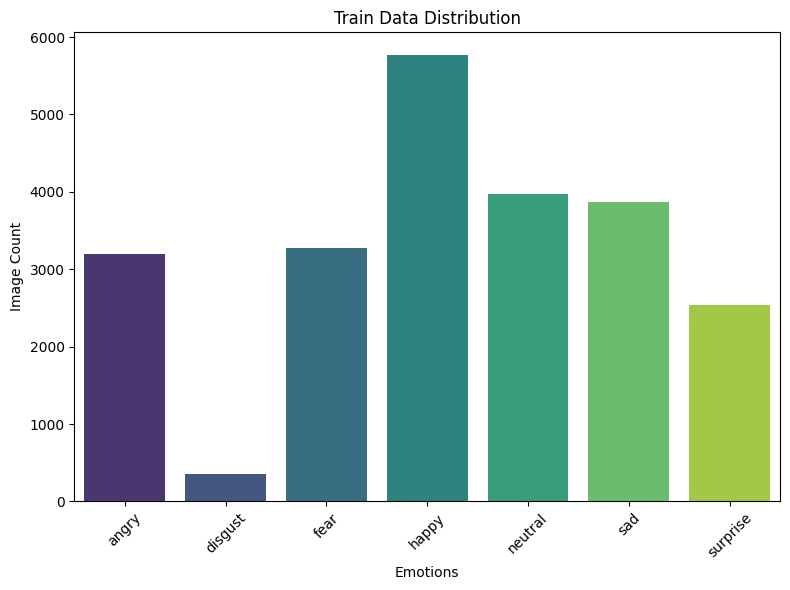

In [8]:
class_labels = list(train_generator.class_indices.keys())
class_counts = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)]

plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=class_counts, palette="viridis")

plt.xlabel('Emotions')
plt.ylabel('Image Count')
plt.title('Train Data Distribution')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

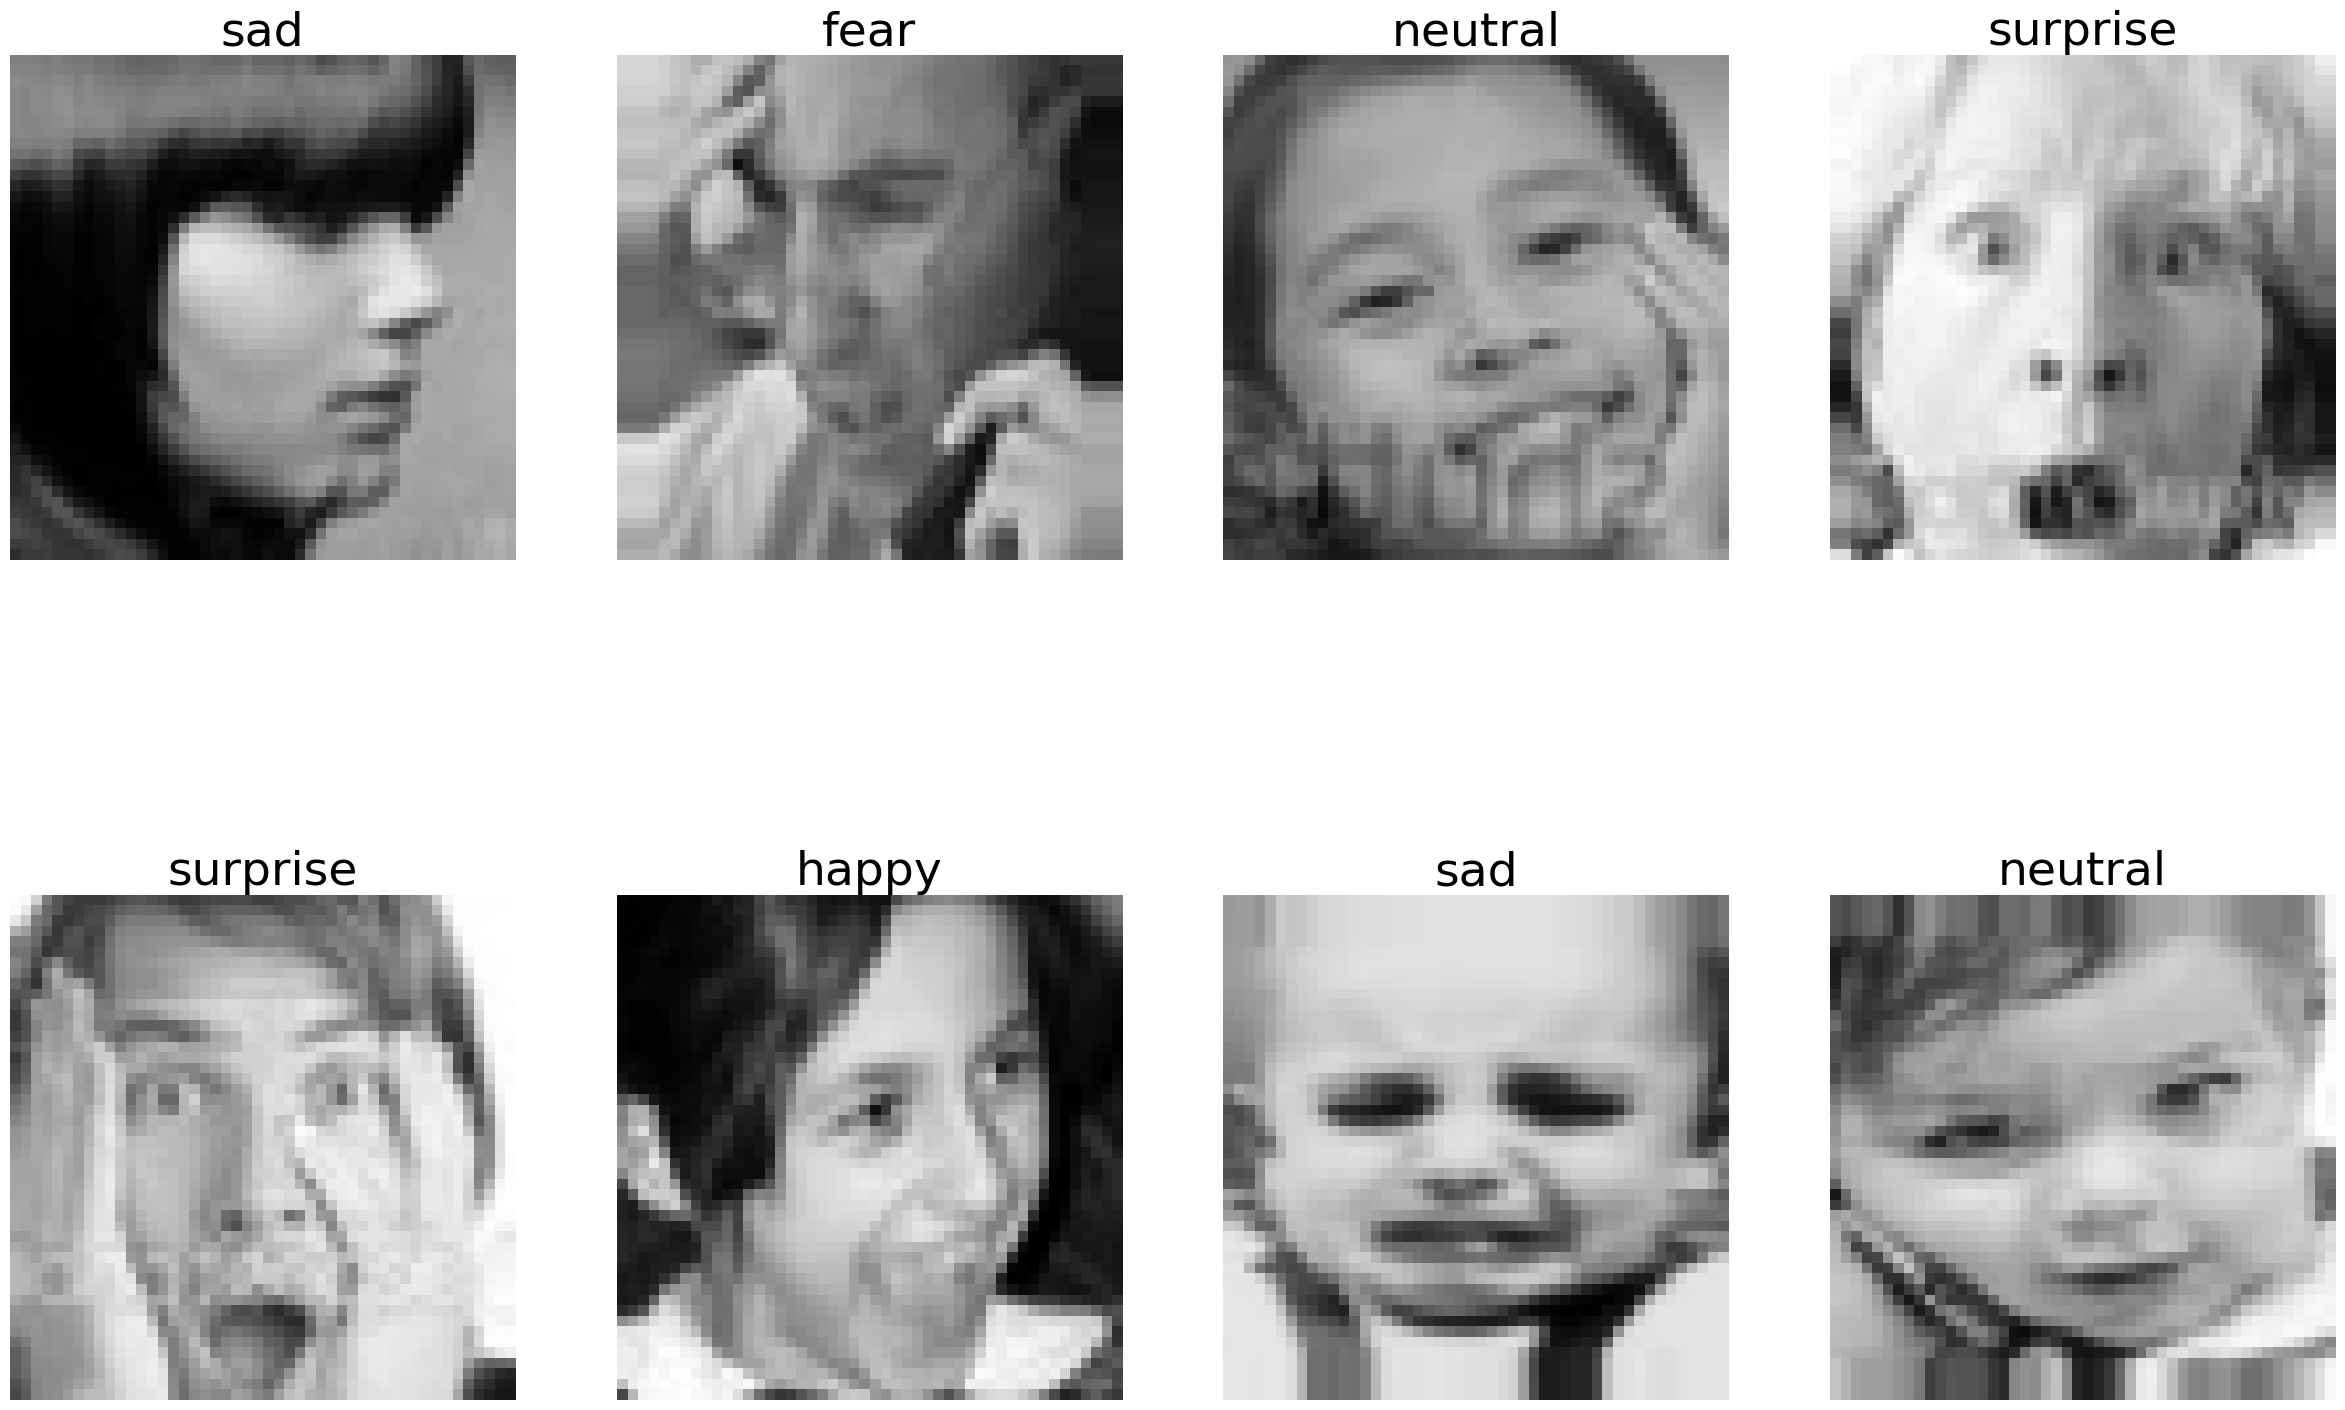

In [9]:
batch = next(train_generator)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30, 20))

for i in range(2):
    for j in range(4):
        index = i * 4 + j
        img = batch[0][index]
        img_class = class_labels[np.argmax(batch[1][index])]
        
        ax[i, j].imshow(img)
        ax[i, j].set_title(img_class, fontsize=34)
        ax[i, j].axis('off')

plt.show()

# Transfer Learning using Own Architecture

In [10]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48, 48, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [12]:
history = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/30


I0000 00:00:1718850542.944294    1002 service.cc:145] XLA service 0x7e8554008040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718850542.944339    1002 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1718850542.944343    1002 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  4/718 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.1003 - loss: 2.0096 

I0000 00:00:1718850551.861246    1002 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 ━━━━━━━━━━━━━━━━━━━━ 88s 106ms/step - accuracy: 0.2283 - loss: 1.8448 - val_accuracy: 0.2513 - val_loss: 1.8681
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 125s 95ms/step - accuracy: 0.2499 - loss: 1.8055 - val_accuracy: 0.3161 - val_loss: 1.7327
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 67s 92ms/step - accuracy: 0.3203 - loss: 1.6923 - val_accuracy: 0.3426 - val_loss: 1.6271
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 69s 95ms/step - accuracy: 0.3704 - loss: 1.6099 - val_accuracy: 0.4107 - val_loss: 1.5280
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 66s 92ms/step - accuracy: 0.4020 - loss: 1.5387 - val_accuracy: 0.4403 - val_loss: 1.4466
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 66s 91ms/step - accuracy: 0.4360 - loss: 1.4692 - val_accuracy: 0.4687 - val_loss: 1.3955
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 67s 92ms/step - accuracy: 0.4617 - loss: 1.4151 - val_accuracy: 0.4855 - val_loss: 1.3455
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 66s 92ms/step - accuracy: 0.4713 - loss: 1.3734 - val_accur

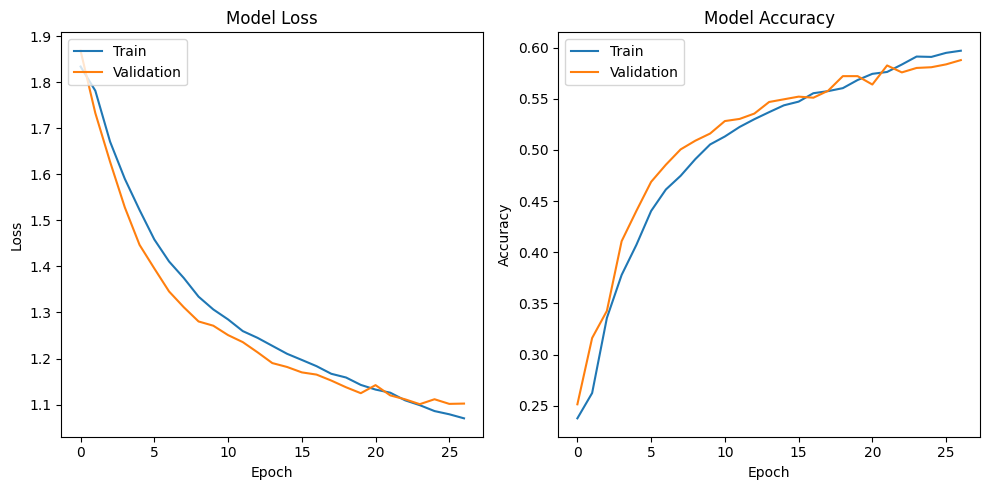

In [13]:
def plot_graphs(history):
    # To Plot training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # To Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_graphs(history)

In [14]:
model.save("emd_dense201.keras")

In [15]:
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

predicted_classes = predictions.argmax(axis=1)

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 47s 207ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5452 - loss: 1.1865
Test loss: 1.0587056875228882
Test accuracy: 0.6004458069801331


              precision    recall  f1-score   support

       angry       0.51      0.54      0.52       958
     disgust       0.65      0.14      0.22       111
        fear       0.52      0.23      0.32      1024
       happy       0.78      0.86      0.82      1774
     neutral       0.49      0.68      0.57      1233
         sad       0.49      0.43      0.46      1247
    surprise       0.70      0.76      0.73       831

    accuracy                           0.60      7178
   macro avg       0.59      0.52      0.52      7178
weighted avg       0.59      0.60      0.58      7178



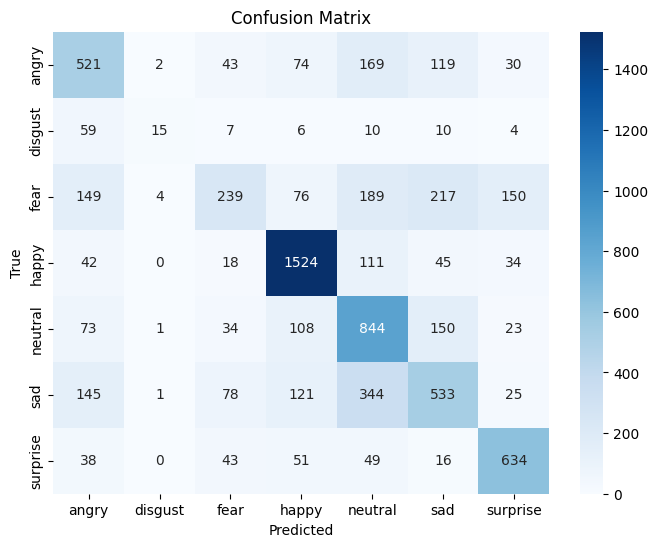

In [16]:
true_classes = test_generator.classes
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()